In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from pathlib import Path
import pandas as pd
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row, Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from synapse.ml.lightgbm import *

pio.renderers.default = "iframe"

In [2]:
def fix_up_df(df: pd.DataFrame):
    log_transform = [
        "n_craters_in_study_region",
        "center_to_center_nearest_neighbor_distance_mean",
        "center_to_center_nearest_neighbor_distance_stdev",
        "center_to_center_nearest_neighbor_distance_min",
        "center_to_center_nearest_neighbor_distance_max",
        "rim_to_rim_nearest_neighbor_distance_mean",
        "rim_to_rim_nearest_neighbor_distance_stdev",
        "rim_to_rim_nearest_neighbor_distance_max",
    ]
    
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["log_n_craters_added_in_study_region"] = np.log(df.n_craters_added_in_study_region)
    df["craters_removed"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
    df["log_craters_removed"] = np.log(1 + df.craters_removed)
    for x in log_transform:
        df[f"log_{x}"] = np.log(1 + df[x])
    return df

# def fix_up_df(df: pd.DataFrame):
#     df["z"] = df.z.fillna(0)
#     df["za"] = df.za.fillna(0)
#     df["percent_rim_to_rim_nearest_neighbors_zero"] = df.n_non_zero_rim_to_rim_nearest_neighbor_distances / df.n_craters_in_study_region
#     df["log_n_craters_added_in_study_region"] = np.log(df.n_craters_added_in_study_region)
#     df["craters_removed"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
#     df["log_craters_removed"] = np.log(1 + df.craters_removed)
#     for x in ivs:
#         df[f"log_{x}"] = np.log(1 + df[x])
#     return df

In [162]:
base_path = "/data/saturation/random_runs_20230812"

ivs = [
    "slope",
    # "effective_radius_multiplier",
    # "r_stat_multiplier",
    # "min_rim_percentage",
    # "z",
    "za",
    "n_craters_in_study_region",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    # "rim_to_rim_nearest_neighbor_distance_mean",
    # "rim_to_rim_nearest_neighbor_distance_stdev",
    # "rim_to_rim_nearest_neighbor_distance_max",
    # "log_rim_to_rim_nearest_neighbor_distance_mean",
    # "log_rim_to_rim_nearest_neighbor_distance_stdev",
    # "log_rim_to_rim_nearest_neighbor_distance_max",
    # "log_center_to_center_nearest_neighbor_distance_mean",
    # "log_center_to_center_nearest_neighbor_distance_stdev",
    # "log_center_to_center_nearest_neighbor_distance_max",
    # "log_n_craters_in_study_region",
]

non_constant_ivs = [
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "rim_to_rim_nearest_neighbor_distance_mean",
    "rim_to_rim_nearest_neighbor_distance_stdev",
    "rim_to_rim_nearest_neighbor_distance_max",
]

In [163]:
sample_size = 100

train_df = pd.read_parquet(f"{base_path}/train_{sample_size}.parquet")
train_df = fix_up_df(train_df)

test_df = pd.read_parquet(f"{base_path}/test_{sample_size}.parquet")
test_df = fix_up_df(test_df)

metric = "information_remaining"

In [164]:
n_cores = 20

spark = SparkSession.builder \
                    .master(f"local[{n_cores}]") \
                    .appName("Saturation") \
                    .config("spark.driver.memory", "48g") \
                    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.11.2") \
                    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                    .getOrCreate()
sc = spark.sparkContext

### LightGBM models

#### Baseline Model

In [165]:
def score_model(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 1):
    sampled = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
    
    X = poly_transform.transform(sampled[ivs])
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
    X[metric] = df[metric]
    
    df_spark = spark.createDataFrame(X)
    spark_X = assembler.transform(df_spark)
    pred_df = model.transform(spark_X).toPandas()
    pred_df["simulation_id"] = df["simulation_id"]
    pred_df["slope"] = df["slope"]
    pred_df["n_craters_added_in_study_region"] = df["n_craters_added_in_study_region"]
    pred_df["effective_radius_multiplier"] = df["effective_radius_multiplier"]
    pred_df["min_rim_percentage"] = df["min_rim_percentage"]
    pred_df["r_stat_multiplier"] = df["r_stat_multiplier"]

    rmse = mean_squared_error(pred_df[metric], pred_df["prediction"], squared=False)
    mape = mean_absolute_percentage_error(pred_df[metric], pred_df["prediction"])
    mae = mean_absolute_error(pred_df[metric], pred_df["prediction"])
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

    residuals = pred_df[metric] - pred_df["prediction"]
    plt.hist(residuals, bins=50)
    plt.show()

    y_pred_mean_model = [df[metric].mean()] * df.shape[0]
    rmse = mean_squared_error(y_pred_mean_model, df[metric], squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, df[metric])
    mae = mean_absolute_error(y_pred_mean_model, df[metric])
    print(f"Mean model: RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    
    return pred_df


def plot_sim_ci(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 250):   
    # Show params
    print(f"Simulation parameters: {df[ivs].iloc[0]}")
    
    ns_max = 100000
    plt.plot(df.n_craters_added_in_study_region.iloc[:ns_max],
             df[metric].iloc[:ns_max])
    plt.xlabel("$N_S$")
    plt.ylabel("$A_d$")
    plt.show()

    pred_df = score_model(model, df, metric, assembler, ivs, features, sample_cadence)
   
    fig = go.Figure()
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["prediction"],
                    mode="lines",
                    name="95% Threshold")

    fig.update_layout(
        xaxis_title="$N_S$",
        yaxis_title=metric
    )

    fig.show()

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(5)
    .setNumLeaves(5)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_5_5 = model

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(10)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_10_50 = model

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(10)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_10_100 = model

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_50 = model

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(100)
    .setNumLeaves(500)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_100_500 = model

23/08/30 15:59:43 WARN TaskSetManager: Stage 154 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 15:59:43 WARN TaskSetManager: Stage 155 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:01:21 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/08/30 16:01:21 WARN TaskSetManager: Stage 156 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1116, MAE: 0.0850, MAPE: 0.4108


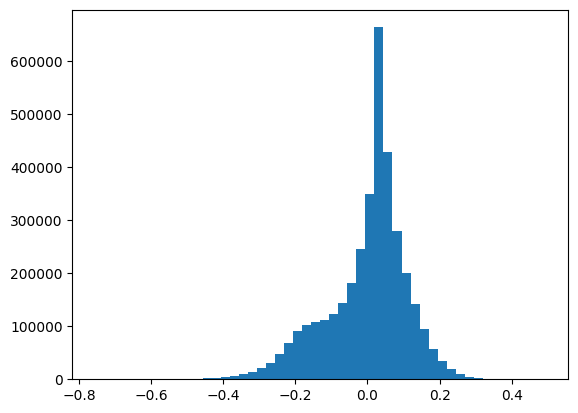

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4746
Training % outside of range: 0.385


23/08/30 16:03:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/08/30 16:03:03 WARN TaskSetManager: Stage 157 contains a task of very large size (4394 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1345, MAE: 0.1018, MAPE: 0.4686


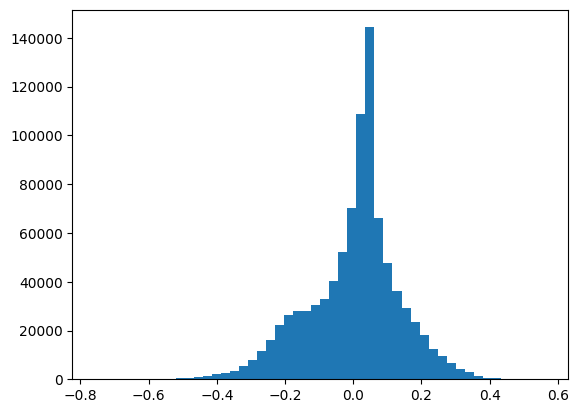

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4761
Testing % outside of range: 0.397
Feature importances:
   slope: 10364.0
   center_to_center_nearest_neighbor_distance_stdev: 8546.0
   center_to_center_nearest_neighbor_distance_mean: 8330.0
   za: 6638.0
   center_to_center_nearest_neighbor_distance_min: 4290.0
   n_craters_in_study_region: 2913.0
   areal_density: 2675.0
   areal_density_overlap_3: 2235.0
   areal_density_overlap_2: 2125.0
   center_to_center_nearest_neighbor_distance_max: 1834.0


In [166]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(50)
    .setNumLeaves(1000)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_1000 = model

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(500)
    .setNumLeaves(500)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_500_500 = model

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_100_median = model

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_100_median_degree_2 = model

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(50)
    .setNumLeaves(1000)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_1000_median_degree_2 = model

In [ ]:
# Best: Test ~11.5% RMSE, 8% MAE
# Best including eff radius, min rim perc: ~10% RMSE, 6.5% MAE
# With log-transformed IVs:

### Plot Predictions

23/08/30 16:05:03 WARN TaskSetManager: Stage 159 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:05:05 WARN TaskSetManager: Stage 160 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:07:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/08/30 16:07:12 WARN TaskSetManager: Stage 161 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1104, MAE: 0.0742, MAPE: 0.3881


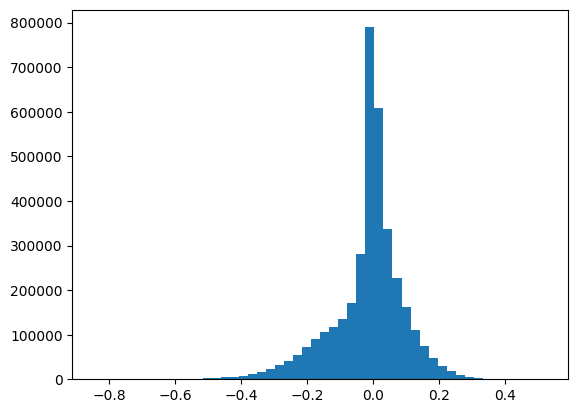

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4746
Training % outside of range: 0.471


23/08/30 16:08:35 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/08/30 16:08:35 WARN TaskSetManager: Stage 162 contains a task of very large size (4394 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1309, MAE: 0.0928, MAPE: 0.4501


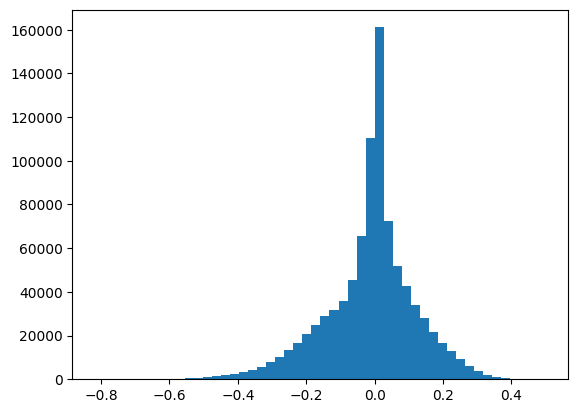

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4761
Testing % outside of range: 0.483
Feature importances:
   slope: 9815.0
   center_to_center_nearest_neighbor_distance_stdev: 6995.0
   za: 6973.0
   center_to_center_nearest_neighbor_distance_mean: 6646.0
   center_to_center_nearest_neighbor_distance_min: 5599.0
   areal_density: 4080.0
   areal_density_overlap_3: 3418.0
   n_craters_in_study_region: 2851.0
   areal_density_overlap_2: 2725.0
   center_to_center_nearest_neighbor_distance_max: 1998.0


In [167]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setLambdaL2(0.05)
    .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(100)
    .setNumLeaves(512)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

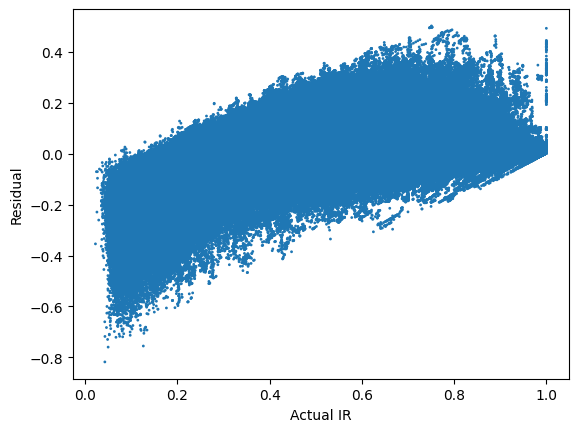

In [168]:
plt.scatter(pred_df[metric], pred_df[metric] - pred_df.prediction, sizes=[1] * pred_df.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Residual")
plt.show()

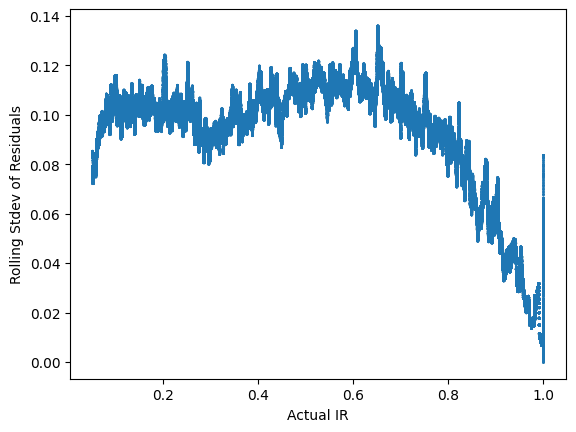

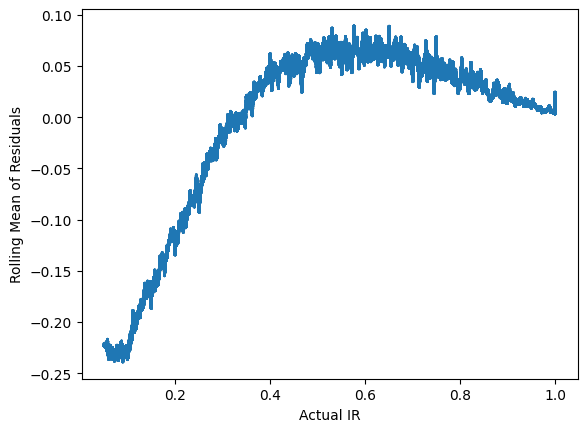

In [169]:
pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Stdev of Residuals")
plt.show()

plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Mean of Residuals")
plt.show()

23/08/30 16:10:30 WARN TaskSetManager: Stage 164 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:10:30 WARN TaskSetManager: Stage 165 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:12:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/08/30 16:12:04 WARN TaskSetManager: Stage 166 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1245, MAE: 0.0901, MAPE: 0.4562


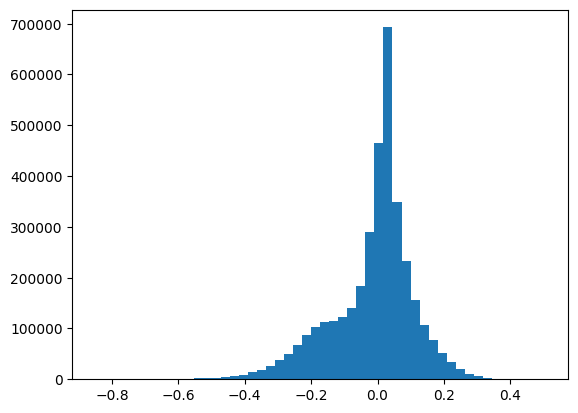

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4746
Training % outside of range: 0.427


23/08/30 16:13:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/08/30 16:13:28 WARN TaskSetManager: Stage 167 contains a task of very large size (4394 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1389, MAE: 0.1027, MAPE: 0.5008


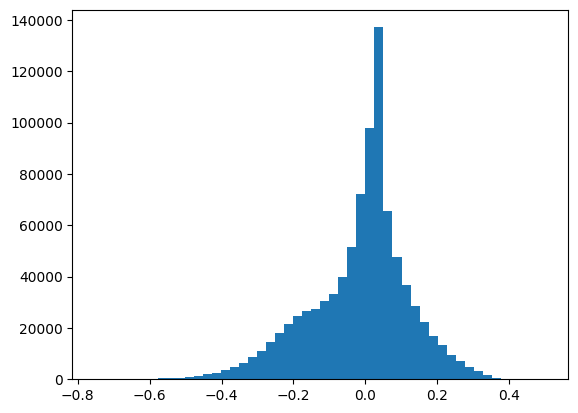

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4761
Testing % outside of range: 0.449
Feature importances:
   slope: 5016.0
   za: 4121.0
   center_to_center_nearest_neighbor_distance_mean: 4106.0
   center_to_center_nearest_neighbor_distance_stdev: 3854.0
   areal_density: 1817.0
   center_to_center_nearest_neighbor_distance_min: 1813.0
   areal_density_overlap_3: 1541.0
   areal_density_overlap_2: 1357.0
   n_craters_in_study_region: 1044.0
   center_to_center_nearest_neighbor_distance_max: 881.0


In [170]:
# Model for IR threshold

threshold = 0.0
xtr = train_df[train_df.information_remaining > threshold].reset_index().copy()
xte = test_df[test_df.information_remaining > threshold].reset_index().copy()

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(xtr[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([xtr[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setLambdaL2(0.05)
    .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(50)
    .setNumLeaves(512)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, xtr, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, xte, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

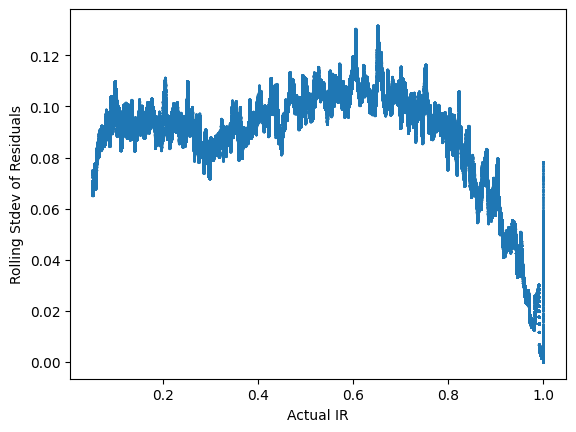

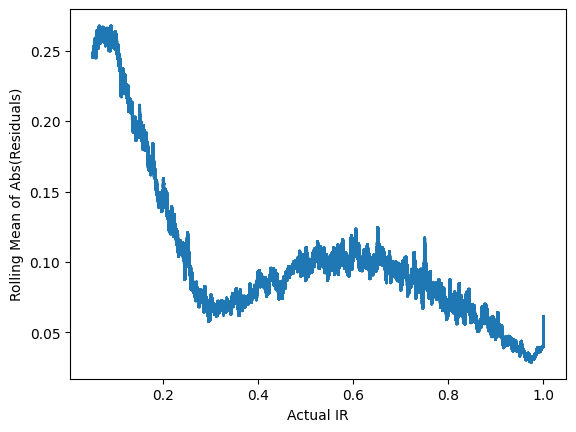

In [171]:
pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Stdev of Residuals")
plt.show()

plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).abs().rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Mean of Abs(Residuals)")
plt.show()

### Plots of 95% CI

In [172]:
min_data_in_leaf = 500
learning_rate = 0.05
n_iterations = 300
n_leaves = 512
boosting_type = "dart"

threshold = 0.0
xtr = train_df[train_df.information_remaining > threshold].reset_index().copy()
xte = test_df[test_df.information_remaining > threshold].reset_index().copy()

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(xtr[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([xtr[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.1)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_10_quantile = model

23/08/30 16:15:23 WARN TaskSetManager: Stage 169 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:15:24 WARN TaskSetManager: Stage 170 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.


In [173]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.50)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_50_quantile = model

23/08/30 16:17:04 WARN TaskSetManager: Stage 172 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:17:04 WARN TaskSetManager: Stage 173 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.


In [174]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.90)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_90_quantile = model

23/08/30 16:18:40 WARN TaskSetManager: Stage 175 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:18:40 WARN TaskSetManager: Stage 176 contains a task of very large size (17965 KiB). The maximum recommended task size is 1000 KiB.


23/08/30 16:20:34 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
23/08/30 16:20:35 WARN TaskSetManager: Stage 177 contains a task of very large size (4394 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.2308, MAE: 0.1868, MAPE: 0.4218


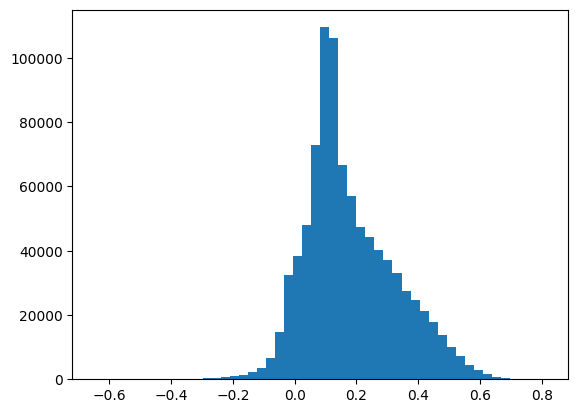

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4761


23/08/30 16:21:11 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
23/08/30 16:21:11 WARN TaskSetManager: Stage 178 contains a task of very large size (4394 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1339, MAE: 0.1047, MAPE: 0.4138


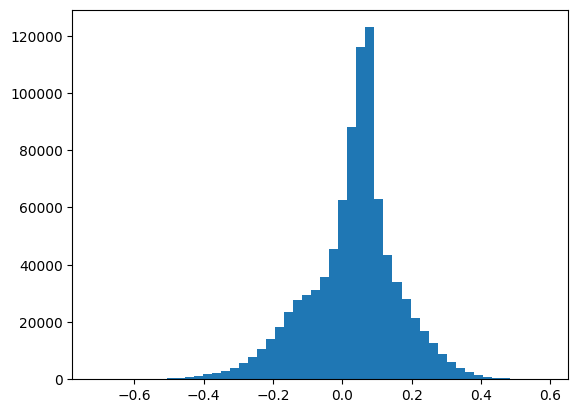

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4761


23/08/30 16:21:54 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
23/08/30 16:21:54 WARN TaskSetManager: Stage 179 contains a task of very large size (4394 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1780, MAE: 0.1273, MAPE: 0.7227


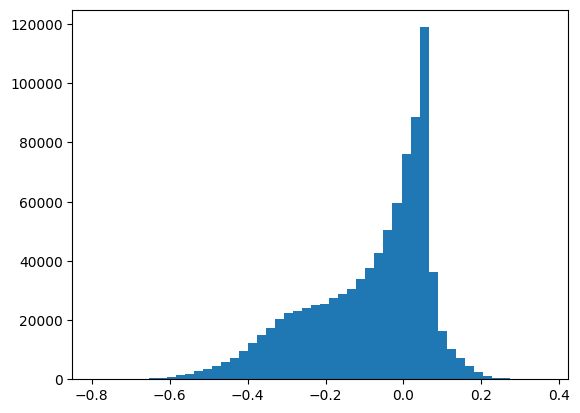

Mean model: RMSE: 0.2900, MAE: 0.2525, MAPE: 0.4761


In [175]:
pred_df_10_quantile = score_model(model_10_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_50_quantile = score_model(model_50_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_90_quantile = score_model(model_90_quantile, xte, metric, assembler, ivs, list(X_train.columns))

pred_df = pred_df_10_quantile.copy()
pred_df["prediction_10_quantile"] = pred_df["prediction"]
pred_df["n_craters_total_10_quantile"] = 1. / pred_df["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["prediction_50_quantile"] = pred_df_50_quantile["prediction"]
pred_df["n_craters_total_50_quantile"] = 1. / pred_df_50_quantile["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["prediction_90_quantile"] = pred_df_90_quantile["prediction"]
pred_df["n_craters_total_90_quantile"] = 1. / pred_df_90_quantile["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["slope"] = test_df["slope"]
pred_df["effective_radius_multiplier"] = test_df["effective_radius_multiplier"]
pred_df["min_rim_percentage"] = test_df["min_rim_percentage"]

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 0, dtype: object


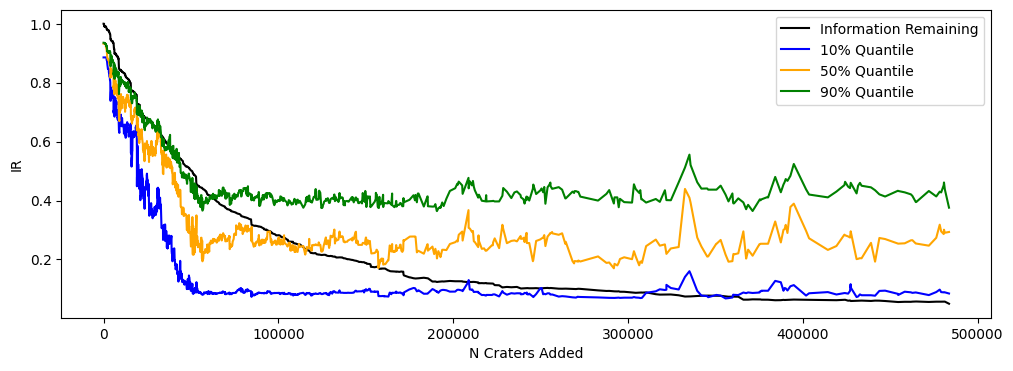

slope                          1.465672
effective_radius_multiplier    1.484714
min_rim_percentage             0.625771
Name: 100, dtype: object


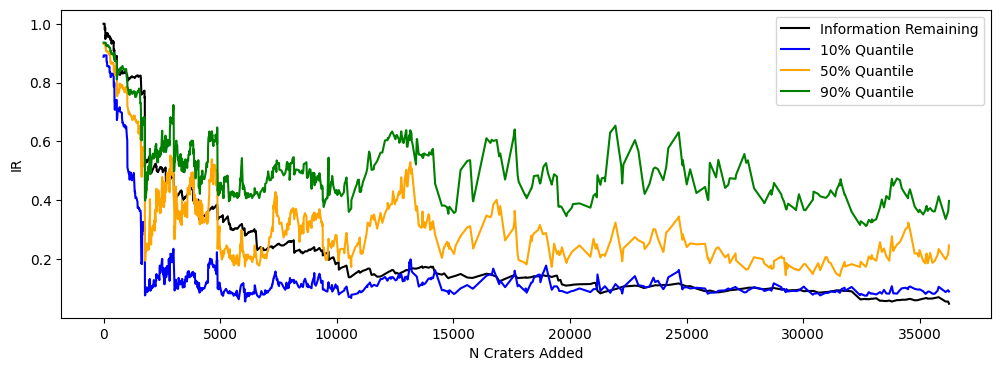

slope                          2.805113
effective_radius_multiplier    1.884478
min_rim_percentage             0.250041
Name: 200, dtype: object


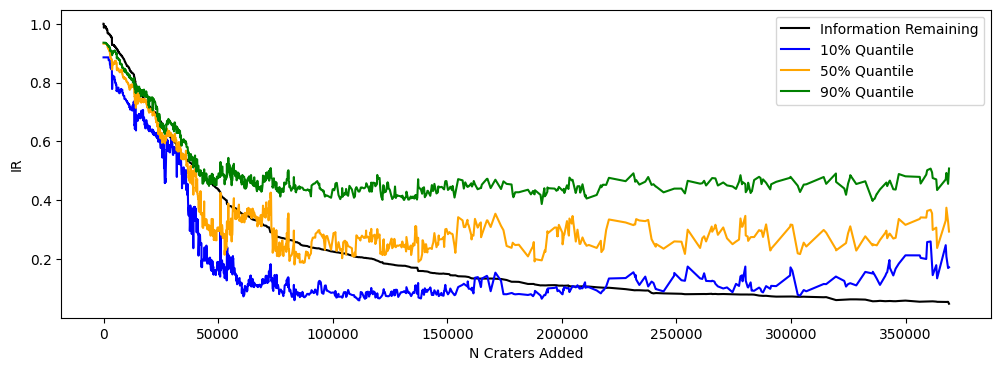

slope                          1.607999
effective_radius_multiplier    1.723657
min_rim_percentage             0.670446
Name: 300, dtype: object


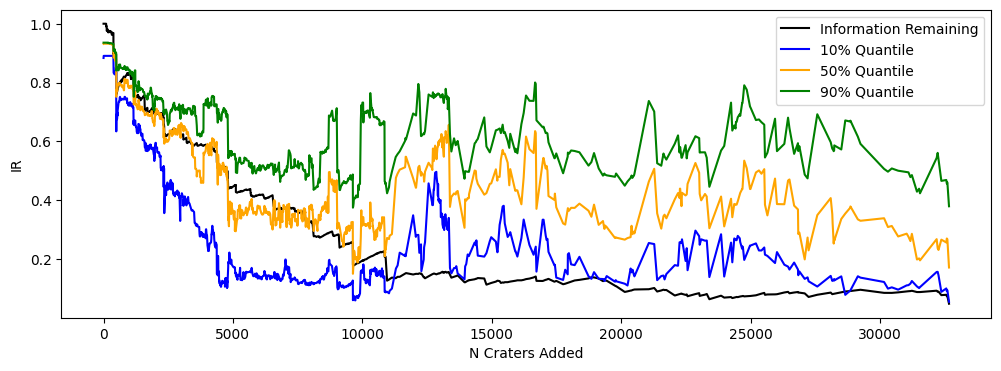

slope                          1.907369
effective_radius_multiplier    1.641525
min_rim_percentage             0.304169
Name: 400, dtype: object


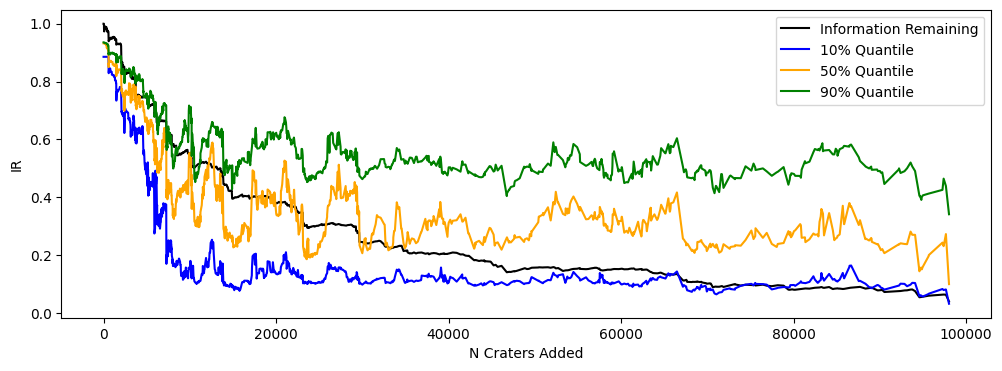

In [177]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:5]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='black', label="Information Remaining")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Added")
    ax1.set_ylabel("IR")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

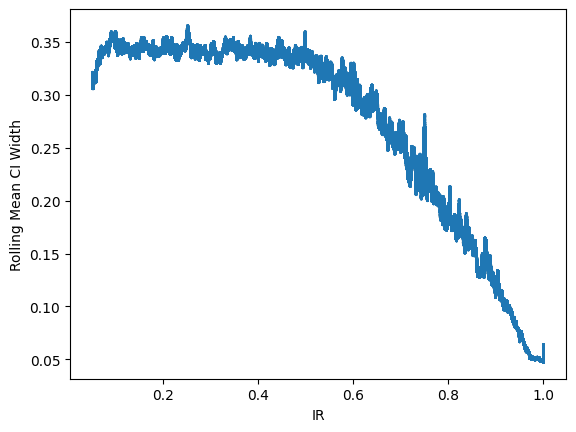

In [178]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Mean CI Width")
plt.show()

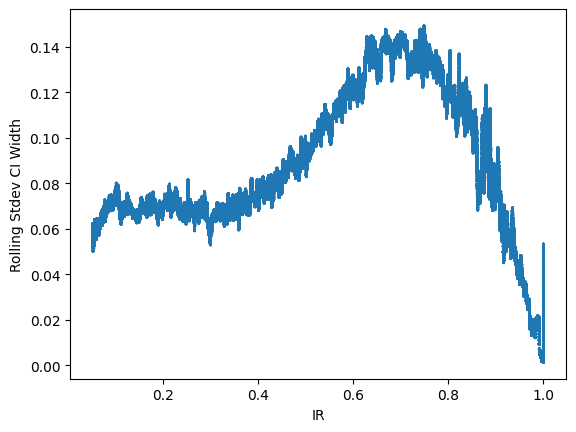

In [179]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Stdev CI Width")
plt.show()

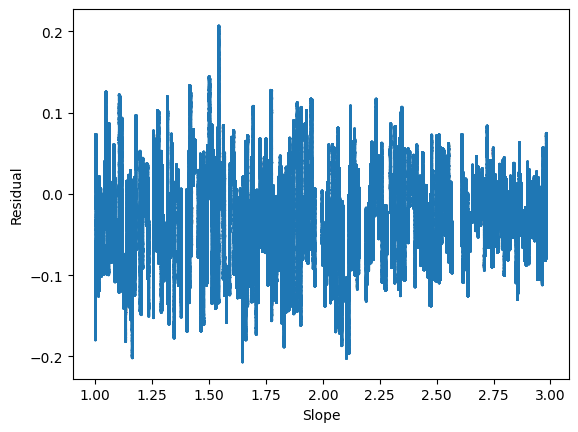

In [180]:
pred_sorted = pred_df.sort_values("slope")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["slope"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Slope")
plt.ylabel("Residual")
plt.show()

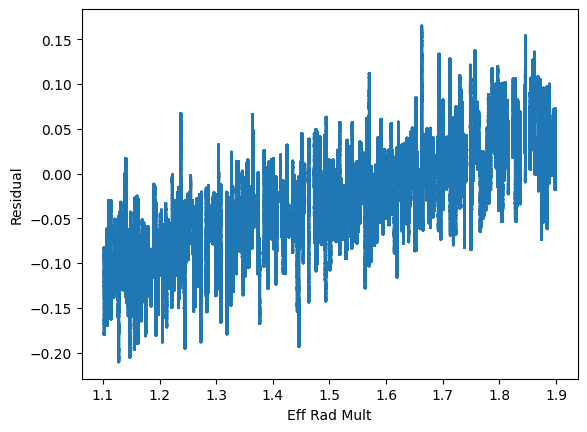

In [181]:
pred_sorted = pred_df.sort_values("effective_radius_multiplier")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["effective_radius_multiplier"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Eff Rad Mult")
plt.ylabel("Residual")
plt.show()

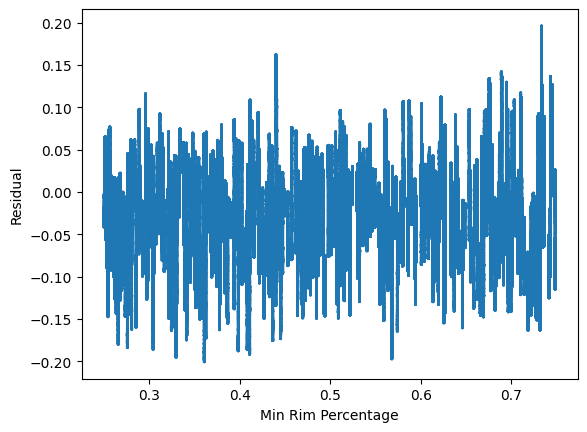

In [182]:
pred_sorted = pred_df.sort_values("min_rim_percentage")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["min_rim_percentage"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Min Rim Percentage")
plt.ylabel("Residual")
plt.show()

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 0, dtype: object


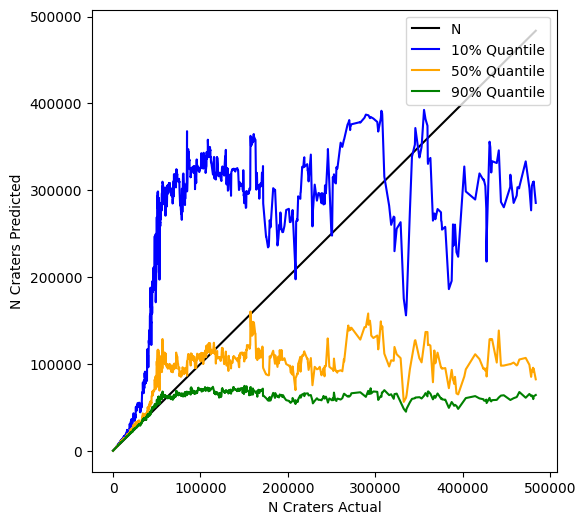

slope                          1.465672
effective_radius_multiplier    1.484714
min_rim_percentage             0.625771
Name: 100, dtype: object


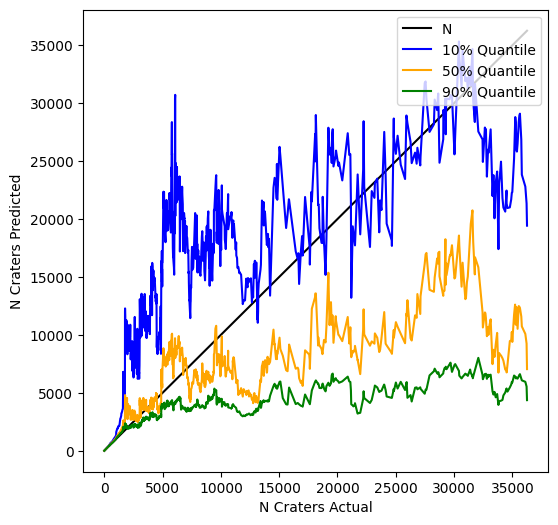

slope                          2.805113
effective_radius_multiplier    1.884478
min_rim_percentage             0.250041
Name: 200, dtype: object


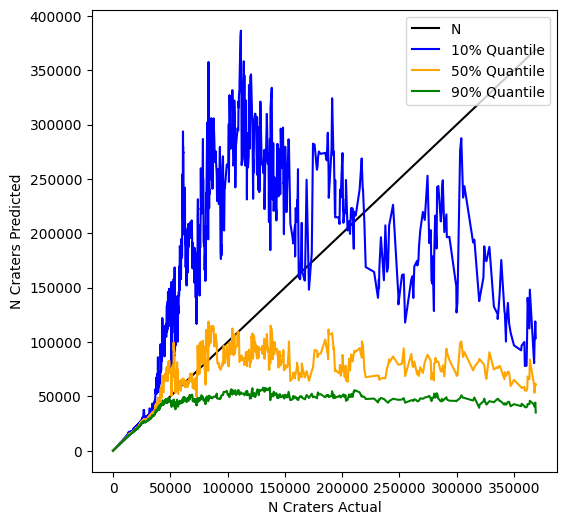

slope                          1.607999
effective_radius_multiplier    1.723657
min_rim_percentage             0.670446
Name: 300, dtype: object


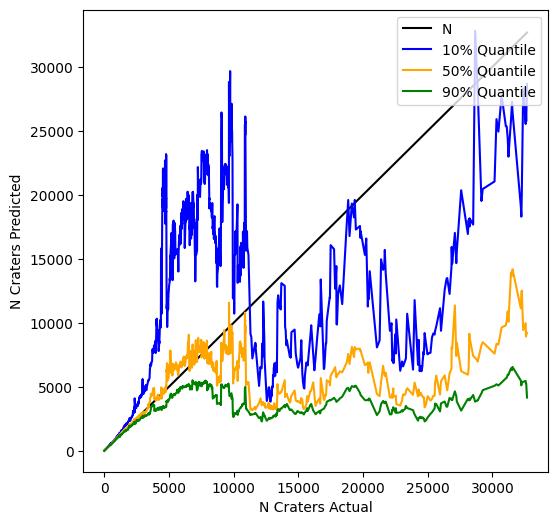

slope                          1.907369
effective_radius_multiplier    1.641525
min_rim_percentage             0.304169
Name: 400, dtype: object


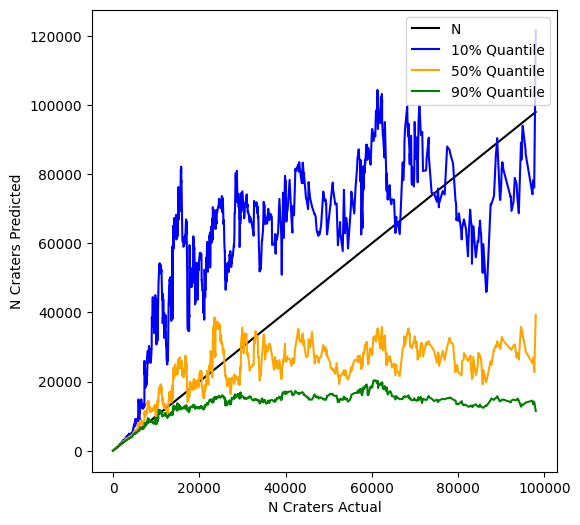

slope                          1.849374
effective_radius_multiplier     1.20519
min_rim_percentage             0.265606
Name: 500, dtype: object


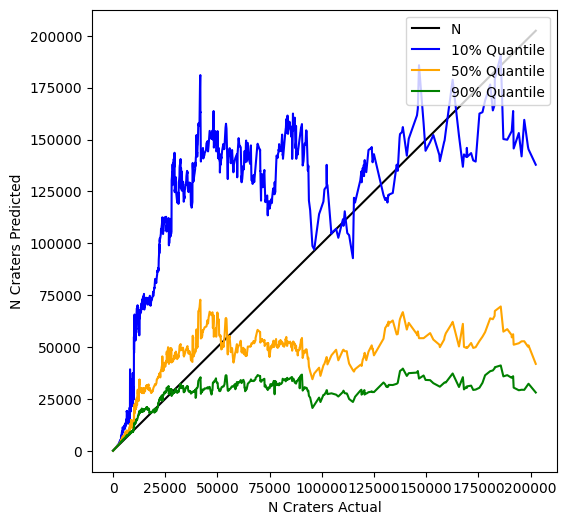

slope                           2.34389
effective_radius_multiplier    1.868235
min_rim_percentage             0.743494
Name: 689, dtype: object


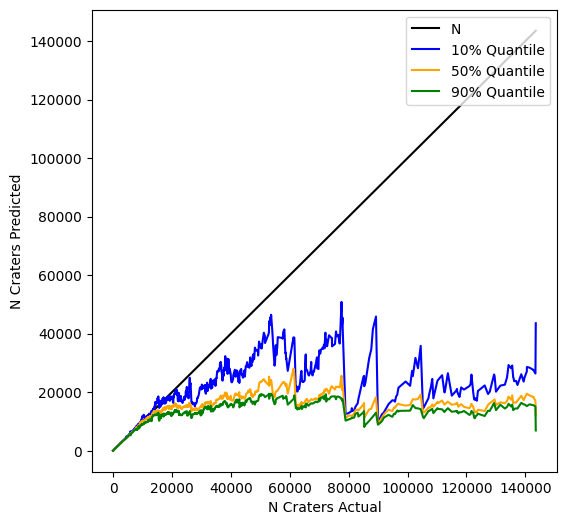

slope                          1.543287
effective_radius_multiplier    1.610255
min_rim_percentage             0.381079
Name: 789, dtype: object


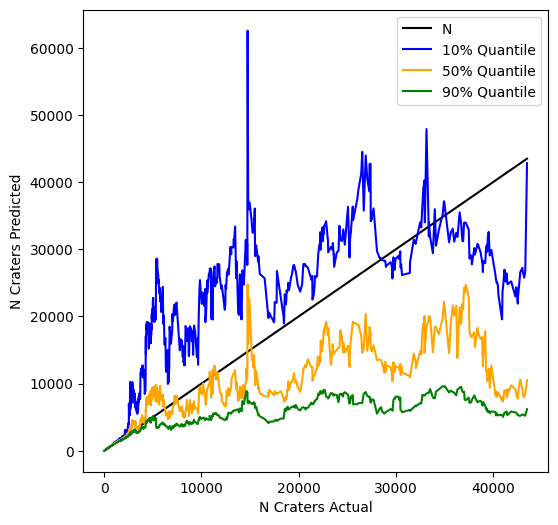

slope                           1.64785
effective_radius_multiplier    1.387136
min_rim_percentage             0.421662
Name: 889, dtype: object


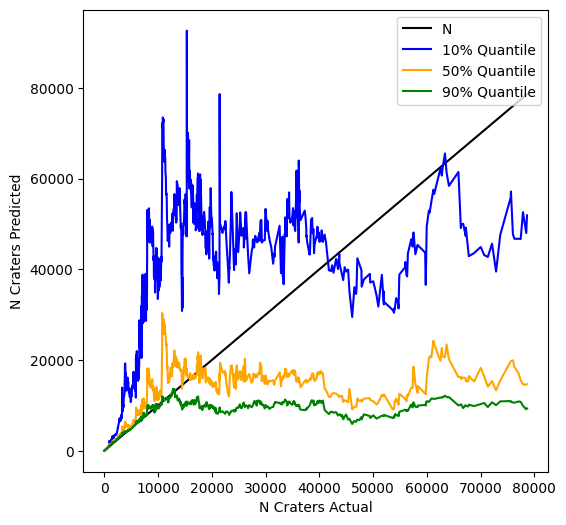

slope                           1.34725
effective_radius_multiplier    1.770975
min_rim_percentage             0.520122
Name: 989, dtype: object


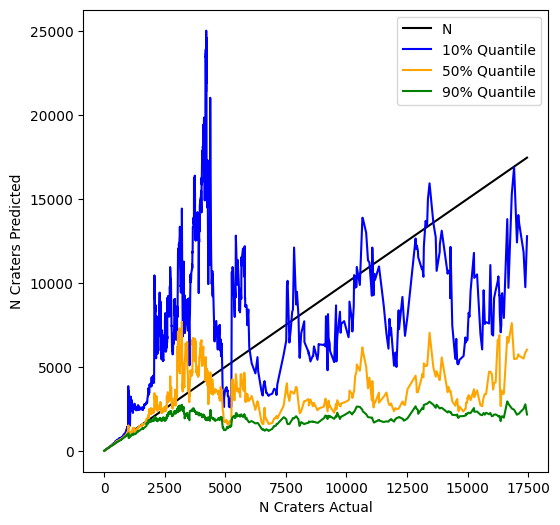

In [192]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:10]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.n_craters_added_in_study_region, color='black', label="N")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Actual")
    ax1.set_ylabel("N Craters Predicted")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

### Limited AD Models

In [214]:
min_data_in_leaf = 500
learning_rate = 0.05
n_iterations = 100
n_leaves = 512
boosting_type = "dart"

threshold = 0.0
ad_threshold = 0.30

xtr = train_df[(train_df.information_remaining > threshold) & (train_df.areal_density < ad_threshold)].reset_index().copy()
xte = test_df[(test_df.information_remaining > threshold) & (test_df.areal_density < ad_threshold)].reset_index().copy()

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(xtr[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([xtr[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.1)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_10_quantile = model

23/08/30 16:56:00 WARN TaskSetManager: Stage 205 contains a task of very large size (10006 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:56:01 WARN TaskSetManager: Stage 206 contains a task of very large size (10006 KiB). The maximum recommended task size is 1000 KiB.


In [215]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.50)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_50_quantile = model

23/08/30 16:56:15 WARN TaskSetManager: Stage 208 contains a task of very large size (10006 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:56:15 WARN TaskSetManager: Stage 209 contains a task of very large size (10006 KiB). The maximum recommended task size is 1000 KiB.


In [216]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.90)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_90_quantile = model

23/08/30 16:56:28 WARN TaskSetManager: Stage 211 contains a task of very large size (10006 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 16:56:28 WARN TaskSetManager: Stage 212 contains a task of very large size (10006 KiB). The maximum recommended task size is 1000 KiB.


23/08/30 16:56:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/08/30 16:56:53 WARN TaskSetManager: Stage 213 contains a task of very large size (2558 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.2788, MAE: 0.2509, MAPE: 0.4227


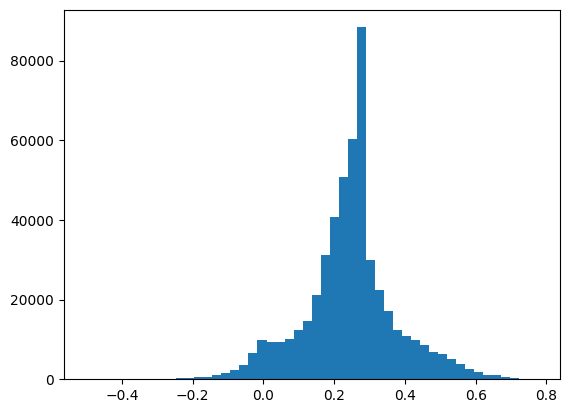

Mean model: RMSE: 0.2812, MAE: 0.2396, MAPE: 0.3649


23/08/30 16:57:14 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/08/30 16:57:14 WARN TaskSetManager: Stage 214 contains a task of very large size (2558 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1767, MAE: 0.1587, MAPE: 0.3546


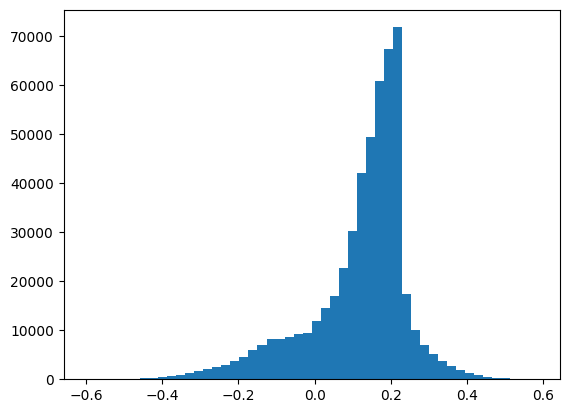

Mean model: RMSE: 0.2812, MAE: 0.2396, MAPE: 0.3649


23/08/30 16:57:36 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/08/30 16:57:36 WARN TaskSetManager: Stage 215 contains a task of very large size (2558 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1823, MAE: 0.1519, MAPE: 0.5386


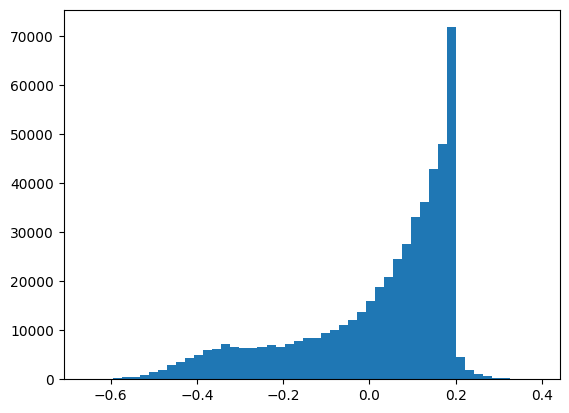

Mean model: RMSE: 0.2812, MAE: 0.2396, MAPE: 0.3649


In [217]:
pred_df_10_quantile = score_model(model_10_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_50_quantile = score_model(model_50_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_90_quantile = score_model(model_90_quantile, xte, metric, assembler, ivs, list(X_train.columns))

pred_df = pred_df_10_quantile.copy()
pred_df["prediction_10_quantile"] = pred_df["prediction"]
pred_df["n_craters_total_10_quantile"] = 1. / pred_df["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["prediction_50_quantile"] = pred_df_50_quantile["prediction"]
pred_df["n_craters_total_50_quantile"] = 1. / pred_df_50_quantile["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["prediction_90_quantile"] = pred_df_90_quantile["prediction"]
pred_df["n_craters_total_90_quantile"] = 1. / pred_df_90_quantile["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["slope"] = test_df["slope"]
pred_df["effective_radius_multiplier"] = test_df["effective_radius_multiplier"]
pred_df["min_rim_percentage"] = test_df["min_rim_percentage"]

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 0, dtype: object


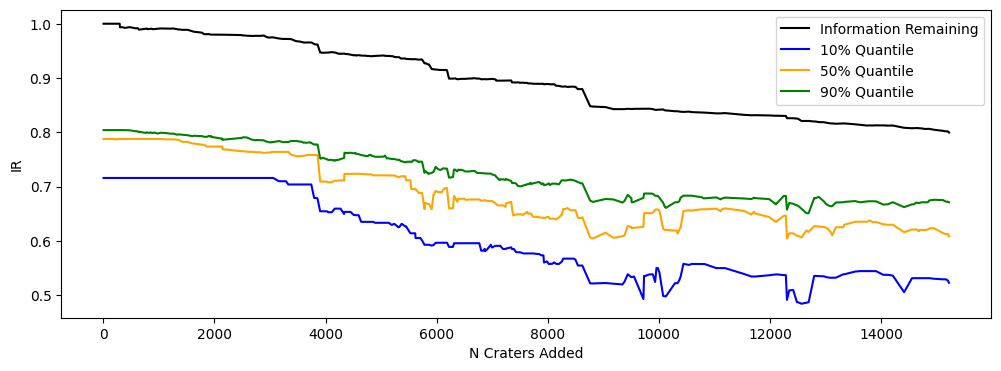

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 1, dtype: object


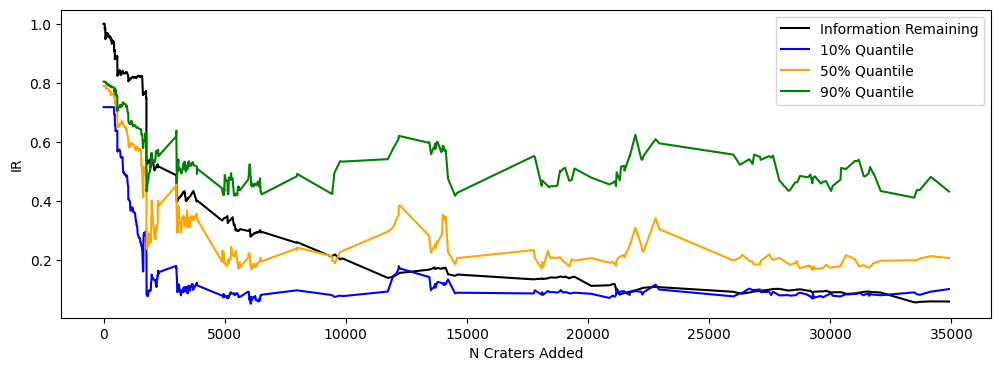

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 9, dtype: object


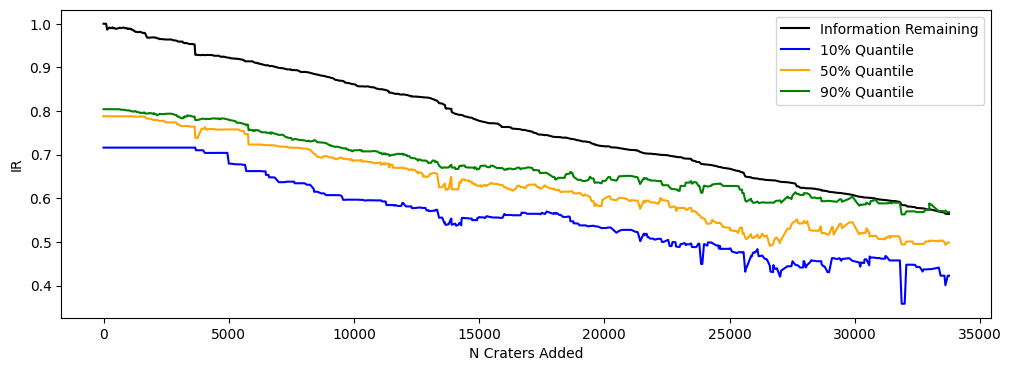

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 75, dtype: object


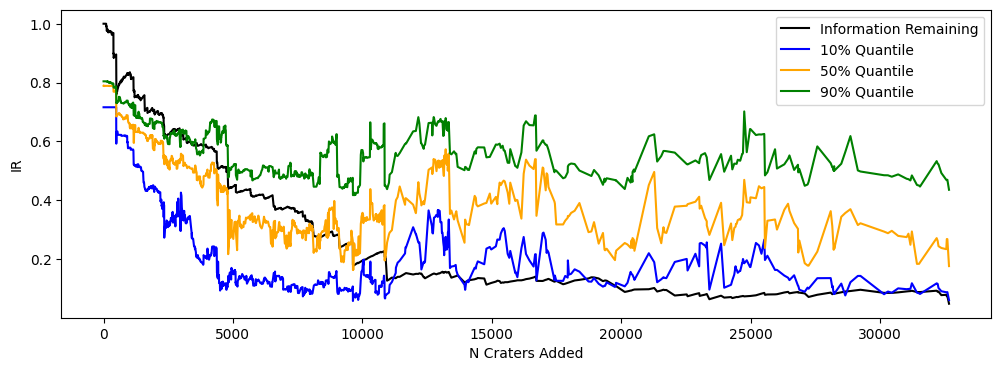

slope                          1.465672
effective_radius_multiplier    1.484714
min_rim_percentage             0.625771
Name: 175, dtype: object


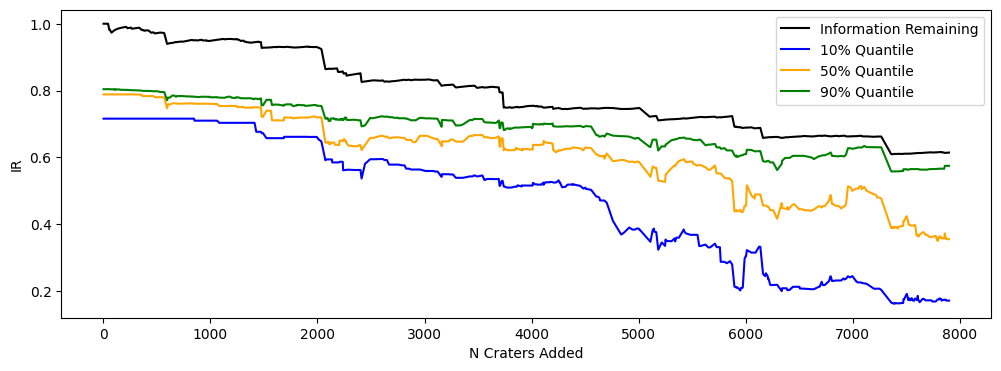

In [218]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:5]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='black', label="Information Remaining")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Added")
    ax1.set_ylabel("IR")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 0, dtype: object


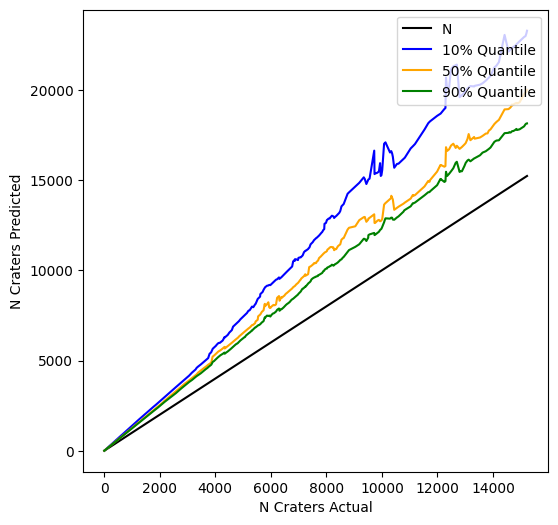

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 1, dtype: object


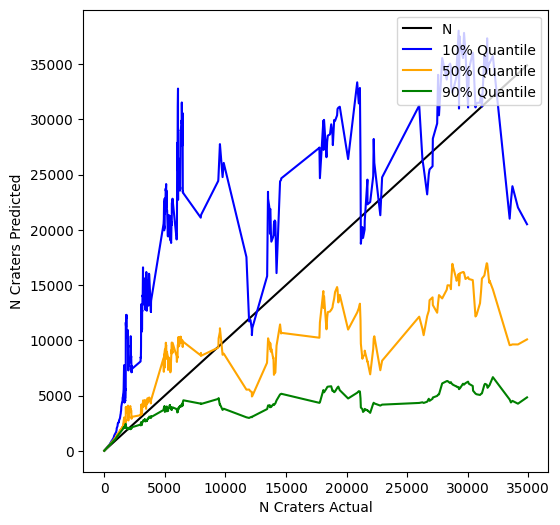

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 9, dtype: object


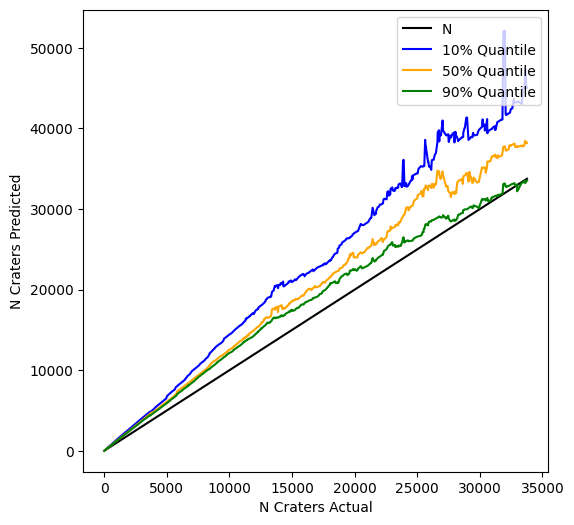

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 75, dtype: object


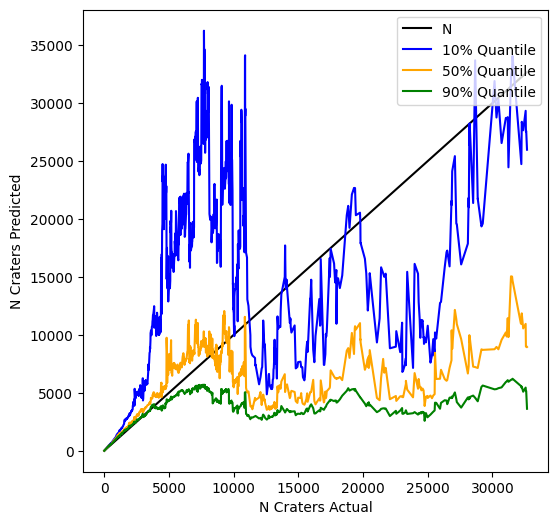

slope                          1.465672
effective_radius_multiplier    1.484714
min_rim_percentage             0.625771
Name: 175, dtype: object


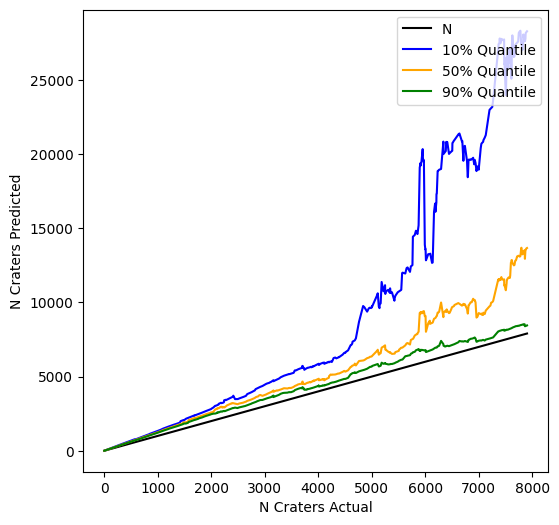

slope                          2.805113
effective_radius_multiplier    1.884478
min_rim_percentage             0.250041
Name: 275, dtype: object


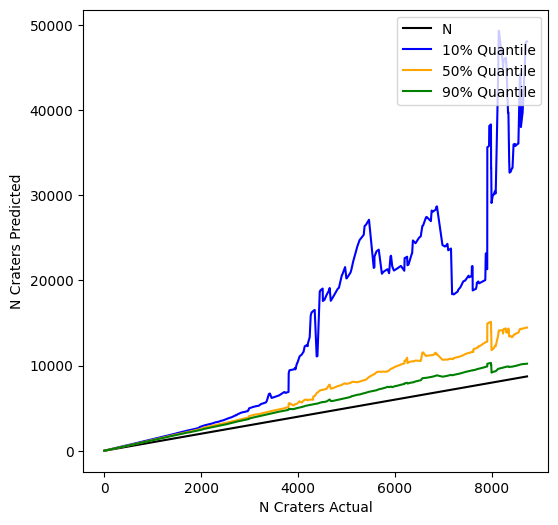

slope                          1.907369
effective_radius_multiplier    1.641525
min_rim_percentage             0.304169
Name: 464, dtype: object


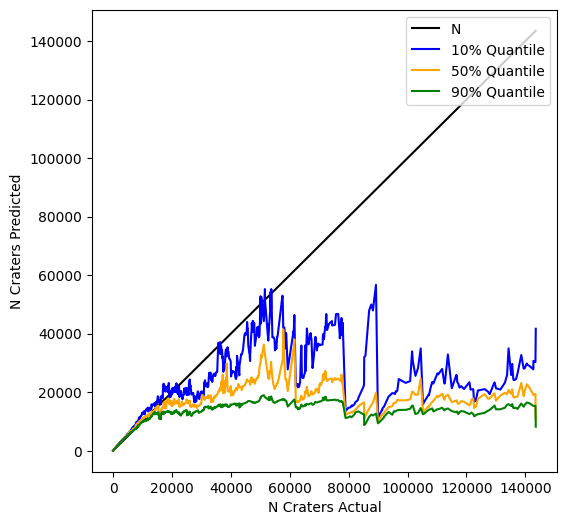

slope                          1.849374
effective_radius_multiplier     1.20519
min_rim_percentage             0.265606
Name: 564, dtype: object


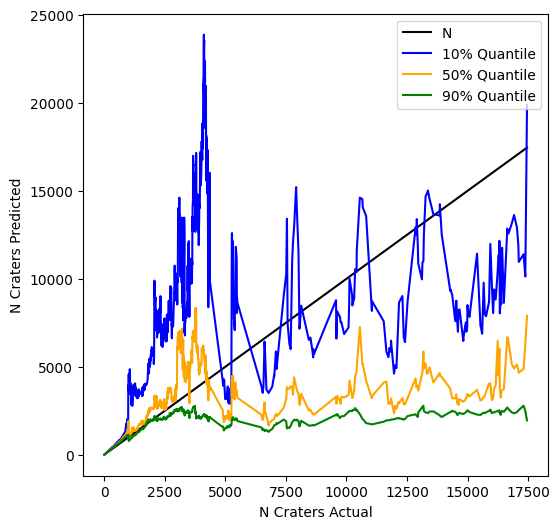

slope                          1.849374
effective_radius_multiplier     1.20519
min_rim_percentage             0.265606
Name: 596, dtype: object


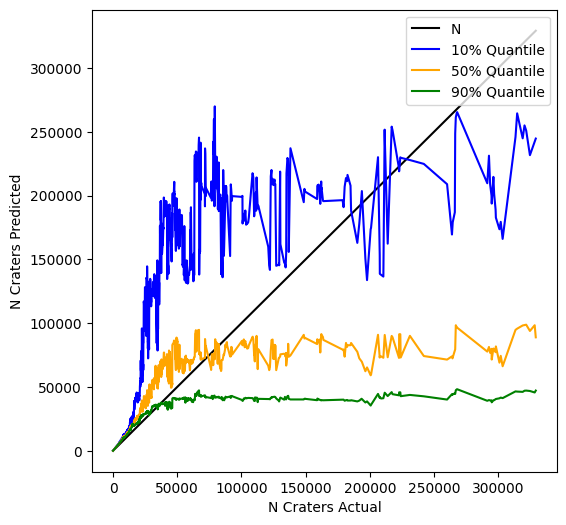

slope                          1.849374
effective_radius_multiplier     1.20519
min_rim_percentage             0.265606
Name: 661, dtype: object


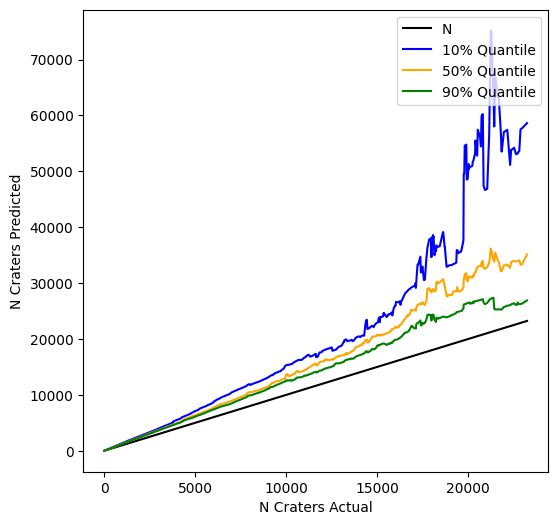

In [219]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:10]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.n_craters_added_in_study_region, color='black', label="N")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Actual")
    ax1.set_ylabel("N Craters Predicted")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

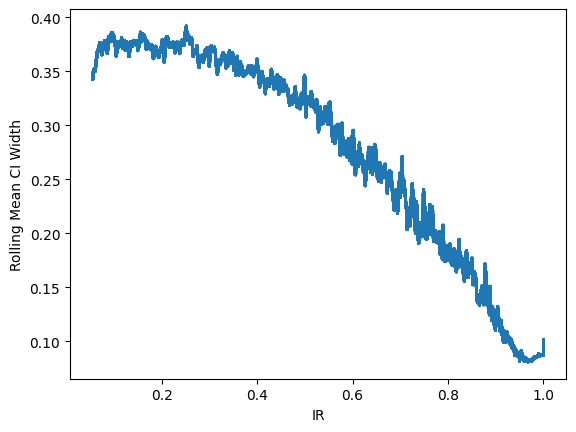

In [220]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Mean CI Width")
plt.show()

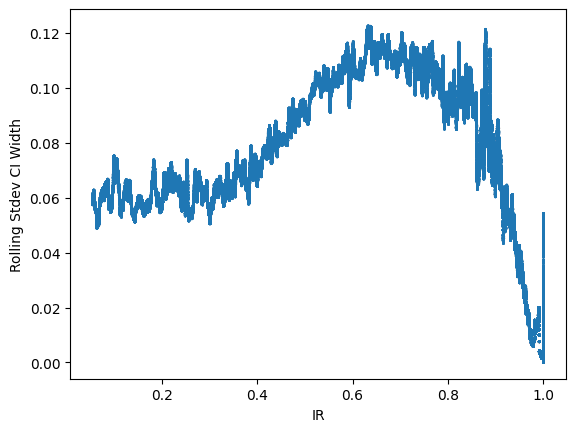

In [221]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Stdev CI Width")
plt.show()

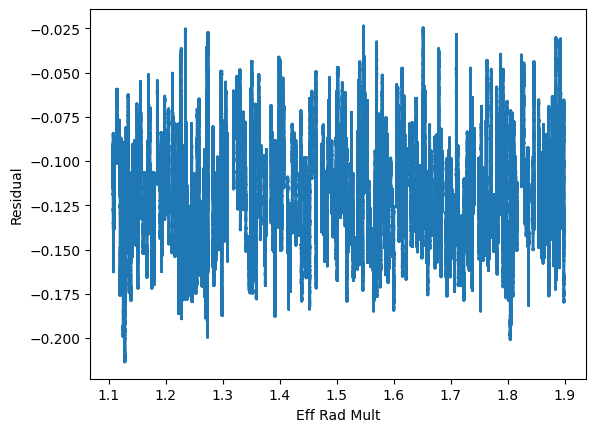

In [222]:
pred_sorted = pred_df.sort_values("effective_radius_multiplier")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["effective_radius_multiplier"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Eff Rad Mult")
plt.ylabel("Residual")
plt.show()

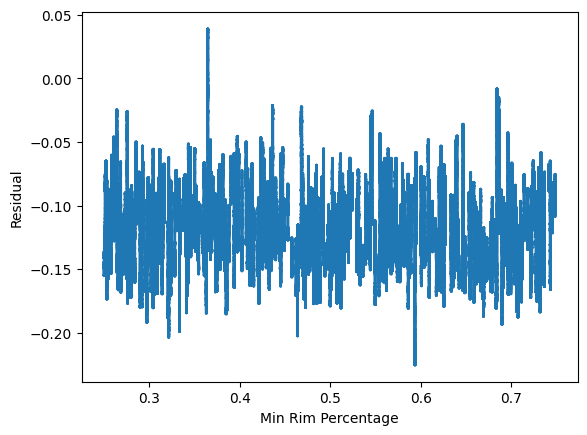

In [223]:
pred_sorted = pred_df.sort_values("min_rim_percentage")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["min_rim_percentage"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Min Rim Percentage")
plt.ylabel("Residual")
plt.show()